<a href="https://colab.research.google.com/github/bustardchad/ML_Turb/blob/main/Turb_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framework for a simple U-net mapping between input and target variables
##  Model outline
#### Training phase

1. Gas density slices are downsampled and then upsampled

2. Loss is calculated as MSE loss against the corresponding target image, gradients are calculated, weights are updated, and we iterate.


#### Training data:
Currently set up to train on the subsonic MHD turbulent box simulations with initial plasma beta ~ 1 (Bustard and Oh 2023)

Data can be presplit or loaded in full



In [1]:
#@title Import packages and download data { display-mode: "form" }

# see what type of GPU we have
!nvidia-smi -L  

# import packages, download turbulence snapshots, etc.
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb
import os

!pip install cmasher
!pip install torchmetrics
#!pip install git+https://github.com/huggingface/diffusers

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

GPU 0: Tesla T4 (UUID: GPU-58a7ec71-6099-2e65-8831-273ee9a7130f)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# default configuration -- some params are changed in for loops later
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    sim_type = 'unet' # either 'unet' or 'classify'
    batch_size = 64
    fileDirArr = ['MHD_beta10']
    field_list = ['density','magnetic_energy_density']
    data_presplit = True # whether data has already been split into training, val, test
    killPwr = False
    use_transforms = False # further augment with horiz/vertical flipping
    # For training
    epochs = 20
    stop_early = False
    patience = 5
    use_ssim = True # add SSIM to loss function
    run_locally = True
    run_colab = True
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    path_to_dir = 'drive/MyDrive/Turb_Sims/Image_Cubes/Multiple_Snapshots_Small/Full_Power/'
    dataset_size = 'small'
    save_dir = 'runs/'
    run_name = 'MHD_Unet_multiple_snapshots_small'

config = TrainingConfig()

## Preprocess the data

In [ ]:
# Download the relevant data from Google Drive
!pip install --upgrade --no-cache-dir gdown
import gdown
"""
if (config.run_locally==False):

    # Path for the FULL google drive file with turb sim data
    # url = "https://drive.google.com/drive/folders/1C9zPwEglOZI7CqiS4Rz2MESCJzS4wTd2"

    # Path for the smaller turb sim data files (without augmentation)
    #url = "https://drive.google.com/drive/folders/1YDXgeazcwfyciAGUv_sW-gHDy7e1k5wY"

    url = "https://drive.google.com/drive/folders/1zzwYNPSV42jyEQVErlbE-CyKGIustlHv"

    if config.killPwr:
      url = "https://drive.google.com/drive/folders/1B7N_x5Y1N0wH96vKubyQ86Oftaz2M8W9"


    #if not os.path.exists("Image_Cubes_noAugment"):
    gdown.download_folder(url)
"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# If on Google Colab, need to clone repo to have access to helper files load_data and interpret_CNN

!git clone https://github.com/bustardchad/ML_Turb

import ML_Turb.utilities.load_data as load_data
#import load_data as load_data
import ML_Turb.utilities.interpret_CNN as interp


from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def batch_imshow(img, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.detach().cpu().numpy(), (1, 2, 0)), cmap='gray')
    plt.show()
"""
for i, data in enumerate(train_dl):
    x, y, z = data  
    batch_imshow(make_grid(x, 8), title = 'Sample density batch')
    batch_imshow(make_grid(y, 8), title = 'Sample magnetic energy density batch')
    break  # we need just one batch
"""

"""
# Using PIL
from PIL import Image
import torchvision

def show_images(x):
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

for i, data in enumerate(train_dl):
    x, y, z = data  
    grid = show_images(x)
    plt.imshow(grid)
    break
"""

fatal: destination path 'ML_Turb' already exists and is not an empty directory.


'\n# Using PIL\nfrom PIL import Image\nimport torchvision\n\ndef show_images(x):\n    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)\n    grid = torchvision.utils.make_grid(x)\n    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255\n    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))\n    return grid_im\n\nfor i, data in enumerate(train_dl):\n    x, y, z = data  \n    grid = show_images(x)\n    plt.imshow(grid)\n    break\n'

Set up loss function, metrics to track

In [8]:
from torchmetrics import StructuralSimilarityIndexMeasure
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

def ssim_loss(x, y, alpha):
    return alpha*(1. - ssim(x, y))

# if val_loss decreases, write a checkpoint of model and return true
# if val_loss has increased for -patience- number of steps, return false
def _early_stopping(config, model, val_loss):
  if (len(val_loss) > 1):
    if (val_loss[-1] < val_loss[-2]):
      print("Saving model checkpoint")
      torch.save(model.state_dict(), config.save_dir + config.run_name+'_checkpoint.pt')
      return True
  if (len(val_loss) > config.patience):
    if ((np.diff(val_loss[-config.patience:]) <= 0).all()):
      print("Early Stopping")
      return False
        
def loss_batch(config, loss_func, prediction, yb, opt=None, struc_alpha = 0.2):
    loss = loss_func(prediction, yb)
    if config.use_ssim:
      struc_loss = ssim_loss(prediction, yb, struc_alpha)
      loss += struc_loss
    else:
      struc_loss = 0
 
    #print(f"Metrics on batch: {batch_metrics}")

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), struc_loss.item(), len(yb)

def fit(config, model, loss_func, opt, train_dl, valid_dl, alpha = 0.2):
    # arrays to store losses
    loss_arr_train = []
    loss_arr_val = []
    struc_arr_train = []
    struc_arr_val = []
    keep_training = True
    for epoch in range(config.epochs):
        model.train()
        train_loss= 0
        train_struc = 0
        num = 0
        for xb, yb, lbl in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)
            
            loss, struc_loss, len = loss_batch(config, loss_func, prediction, 
                                               yb, opt, alpha)
            if config.use_ssim:
              train_struc += -(struc_loss/alpha - 1.0)*len
            
            train_loss += (loss*len)
            num += len

        train_loss = train_loss/num
        if config.use_ssim:
          train_struc = train_struc/num # average SSIM value (1.0 is best)

        #print(f"current training stats={tracker_train.compute()}") 

        model.eval()
        with torch.no_grad():
          val_loss = 0
          val_struc = 0
          num = 0
          for xb, yb, lbl in valid_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)

            loss, struc_loss, len = loss_batch(config, loss_func, prediction, yb, None, alpha)

            if config.use_ssim:
              val_struc += -(struc_loss/alpha - 1.0)*len
            
            val_loss += (loss*len)
            num += len

        if config.use_ssim:
          val_struc = val_struc/num
        
        val_loss = val_loss/num    

        #print(f"current validation stats={tracker_val.compute()}") 
        
        loss_arr_train.append(train_loss)
        loss_arr_val.append(val_loss)

        if config.use_ssim:
          struc_arr_train.append(train_struc)
          struc_arr_val.append(val_struc)


        # Print out what's happening every epoch
        if epoch % 1 == 0:
          print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}| Validation loss: {val_loss:.5f}")

        # early_stopping needs the validation loss to check if it has decreased, 
        # and if it has, it will make a checkpoint of the current model
        keep_training = _early_stopping(config, model, loss_arr_val)
        
        if ((keep_training==False) and (config.stop_early==True)):
          print("Early Stopping")
          # load the last checkpoint with the best model
          model.load_state_dict(torch.load(config.save_dir+config.run_name+'_checkpoint.pt'))
          break

    return model, loss_arr_train, loss_arr_val, struc_arr_train, struc_arr_val
 

In [15]:
from ML_Turb.utilities.unet import UNet

def create_model(config):
  # TODO: Change this part to use unet.py from elektronn3
  model = UNet(in_channels=1,
             out_channels=1,
             #n_blocks=3,
             n_blocks=4,
             start_filts=8,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

  # learning rate and momentum (only for SGD)
  lr = 0.001
  mmtm = 0.9

  #loss_fn = nn.CrossEntropyLoss()
  loss_fn = nn.MSELoss() #default reduction='mean'

  #opt = torch.optim.SGD(model.parameters(),
  #                            lr=lr,momentum=mmtm)
  opt = torch.optim.AdamW(model.parameters(),
                                lr = 1.e-2, 
                                weight_decay = 1.e-2)

  return model, loss_fn, opt

  

## Run the U-net


In [ ]:
# Uncomment and run below to check that U-net input and output
# shapes match 
"""
torch.cuda.empty_cache()

# create the model
model, loss_fn, opt = create_model(config)


for data in iter(train_dl):
    x, y, z = data
    print(x.dtype, y.dtype, z.dtype)
    print(x.shape, y.shape, z.shape)
    with torch.no_grad():
        out = model(x.to(device))
        print(f'Out: {out.shape}')

    break # just do one
"""

"\nfor data in iter(train_dl):\n    x, y, z = data\n    print(x.dtype, y.dtype, z.dtype)\n    print(x.shape, y.shape, z.shape)\n    with torch.no_grad():\n        out = model(x.to(device))\n        print(f'Out: {out.shape}')\n\n    break # just do one\n"

In [16]:
def plot_results(config, model_eval, data_loader):
  #model_eval = model_cuda.to('cpu')
  model_eval.eval()

  # access a batch of labelled images
  dataiter = iter(data_loader)
  x_arr, y_arr, labels = next(dataiter)

  n_examples = 6
  fig, axs = plt.subplots(3,n_examples,figsize=(int(8*n_examples/3),8))
  with plt.style.context('fast'):
    for i in range(0,n_examples):
      x = x_arr[i]
      y = y_arr[i]
      # requires a 4D tensor, so need to reshape this 3D one
      image = x.reshape(1, 1, x.shape[1], x.shape[2])
      target = y.reshape(1, 1, y.shape[1], y.shape[2])
      
      target = target.reshape(target.shape[2],target.shape[3])
      target = target.detach().numpy()


      # we need to find the gradient with respect to the input image, so we need to call requires_grad_  on it
      image.requires_grad_()
      
      # run the model on the image
      outputs = model_eval(image)

      #print(ssim(y.reshape(1,1,128,128), outputs))
      #print(loss_fn(y.reshape(1,1,128,128), outputs))

      input_image = image.reshape(image.shape[2],image.shape[3])
      input_image = input_image.detach().numpy()

      target_image = outputs.reshape(image.shape[2],image.shape[3])
      target_image = target_image.detach().numpy()
      
      axs[0,i].imshow(input_image,cmap='gray')
      axs[1,i].imshow(target,cmap='gray')
      axs[2,i].imshow(target_image,cmap='gray')
      
  
    cols = ['Example {}'.format(col) for col in range(1, n_examples+1)]
    rows = ['Input', 'Real Target', 'Modeled Target']

    for ax, col in zip(axs[0], cols):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()
    #plt.savefig(config.save_dir+config.run_name+'_images.png',dpi=600)
    plt.close()
  #plt.savefig("Unet_first_attempt.png",dpi=600)
  #plt.close()

mkdir: cannot create directory ‘runs’: File exists
Epoch: 0 | Train Loss: 0.10718| Validation loss: 0.10039
Epoch: 1 | Train Loss: 0.09848| Validation loss: 0.10024
Saving model checkpoint
Epoch: 2 | Train Loss: 0.09827| Validation loss: 0.10037
Epoch: 3 | Train Loss: 0.09826| Validation loss: 0.10067
Epoch: 4 | Train Loss: 0.09824| Validation loss: 0.10022
Saving model checkpoint
Epoch: 5 | Train Loss: 0.09819| Validation loss: 0.10018
Saving model checkpoint
Epoch: 6 | Train Loss: 0.09812| Validation loss: 0.10017
Saving model checkpoint
Epoch: 7 | Train Loss: 0.09814| Validation loss: 0.10042
Epoch: 8 | Train Loss: 0.09812| Validation loss: 0.10022
Saving model checkpoint
Epoch: 9 | Train Loss: 0.09814| Validation loss: 0.10017
Saving model checkpoint
Epoch: 10 | Train Loss: 0.09811| Validation loss: 0.10013
Saving model checkpoint
Epoch: 11 | Train Loss: 0.09808| Validation loss: 0.10009
Saving model checkpoint
Epoch: 12 | Train Loss: 0.09808| Validation loss: 0.10016
Epoch: 13 | T

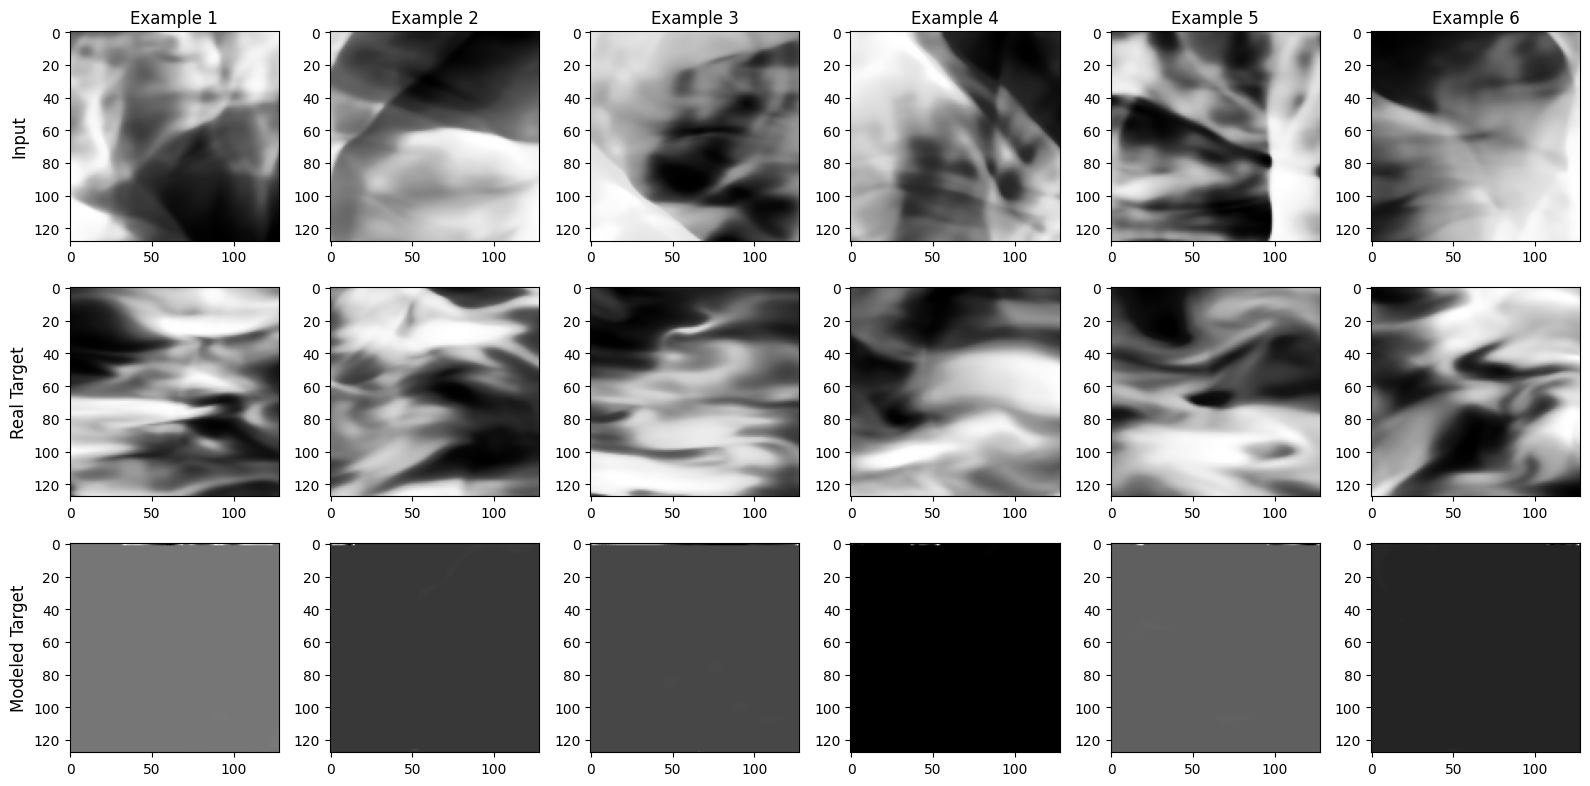

Results on validation data


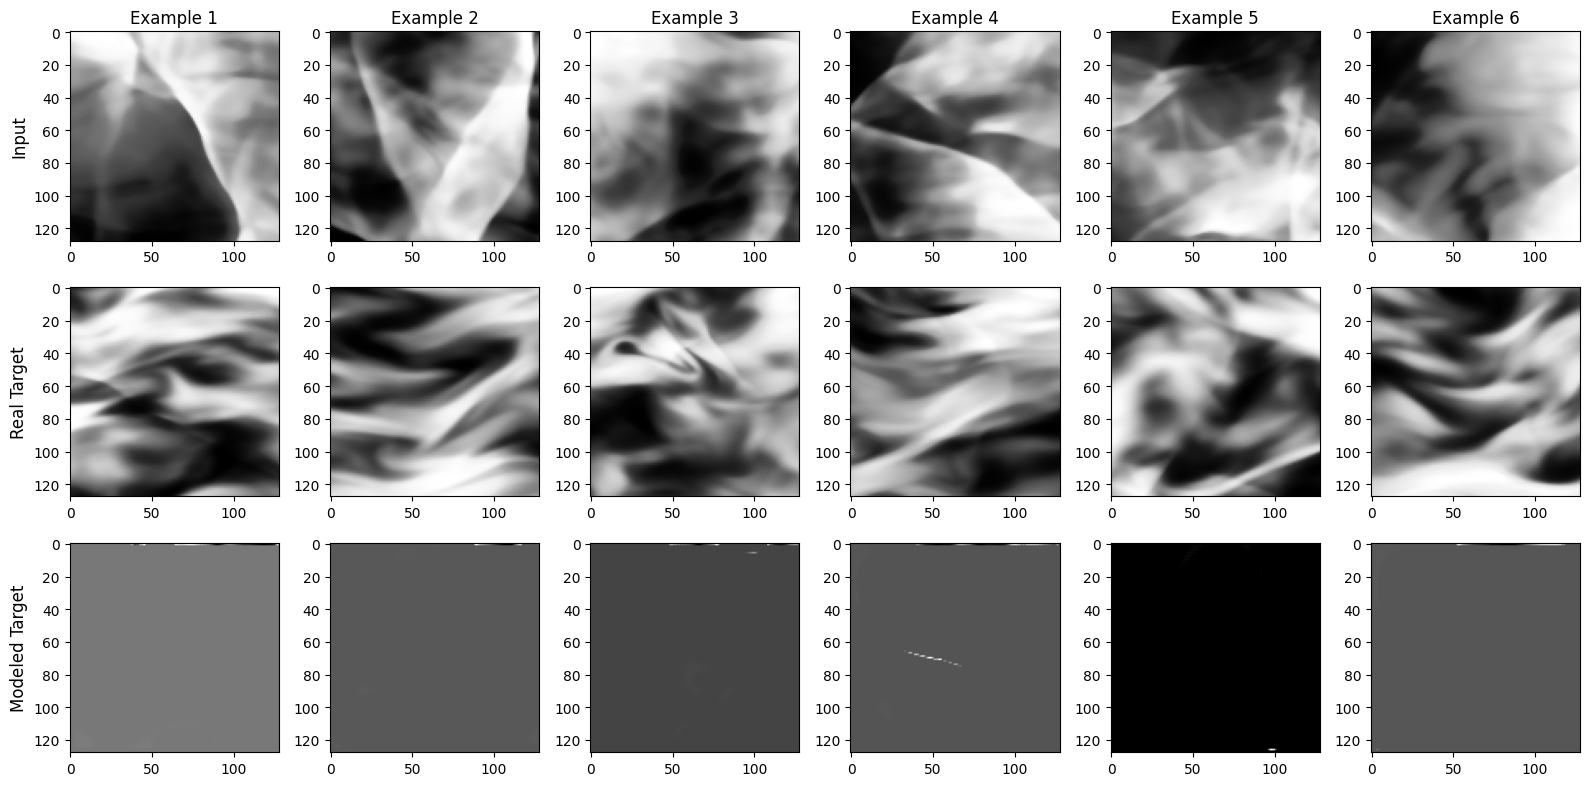

Epoch: 0 | Train Loss: 0.16430| Validation loss: 0.15882
Epoch: 1 | Train Loss: 0.15423| Validation loss: 0.15639
Saving model checkpoint
Epoch: 2 | Train Loss: 0.15402| Validation loss: 0.15656
Epoch: 3 | Train Loss: 0.15395| Validation loss: 0.15673
Epoch: 4 | Train Loss: 0.15400| Validation loss: 0.15643
Saving model checkpoint
Epoch: 5 | Train Loss: 0.15386| Validation loss: 0.15637
Saving model checkpoint
Epoch: 6 | Train Loss: 0.15383| Validation loss: 0.15630
Saving model checkpoint
Epoch: 7 | Train Loss: 0.15384| Validation loss: 0.15639
Epoch: 8 | Train Loss: 0.15380| Validation loss: 0.15641
Epoch: 9 | Train Loss: 0.15378| Validation loss: 0.15636
Saving model checkpoint
Epoch: 10 | Train Loss: 0.15376| Validation loss: 0.15650
Epoch: 11 | Train Loss: 0.15376| Validation loss: 0.15627
Saving model checkpoint
Epoch: 12 | Train Loss: 0.15378| Validation loss: 0.15639
Epoch: 13 | Train Loss: 0.15376| Validation loss: 0.15627
Saving model checkpoint
Epoch: 14 | Train Loss: 0.1537

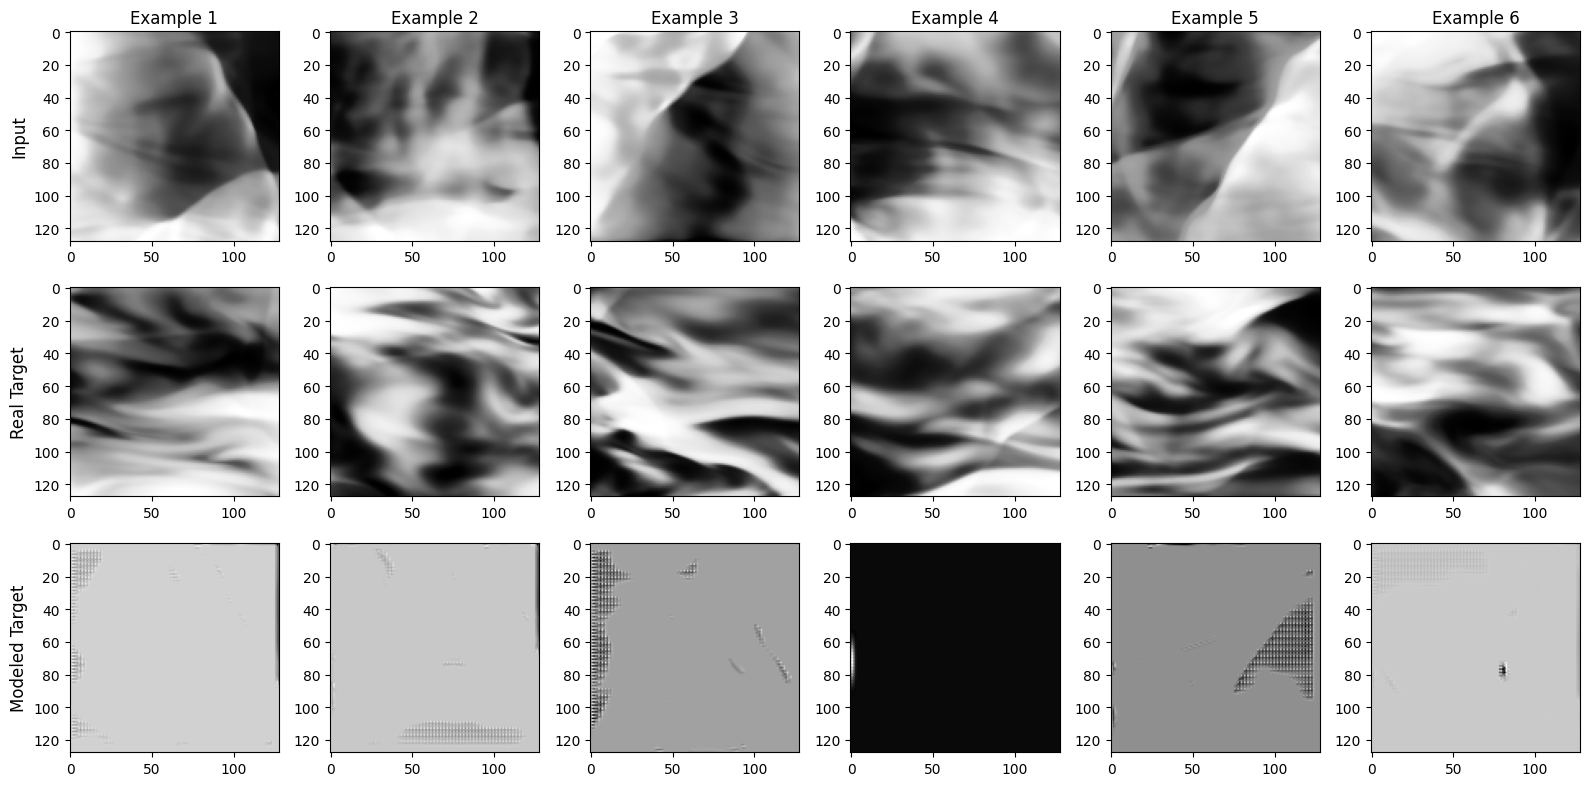

Results on validation data


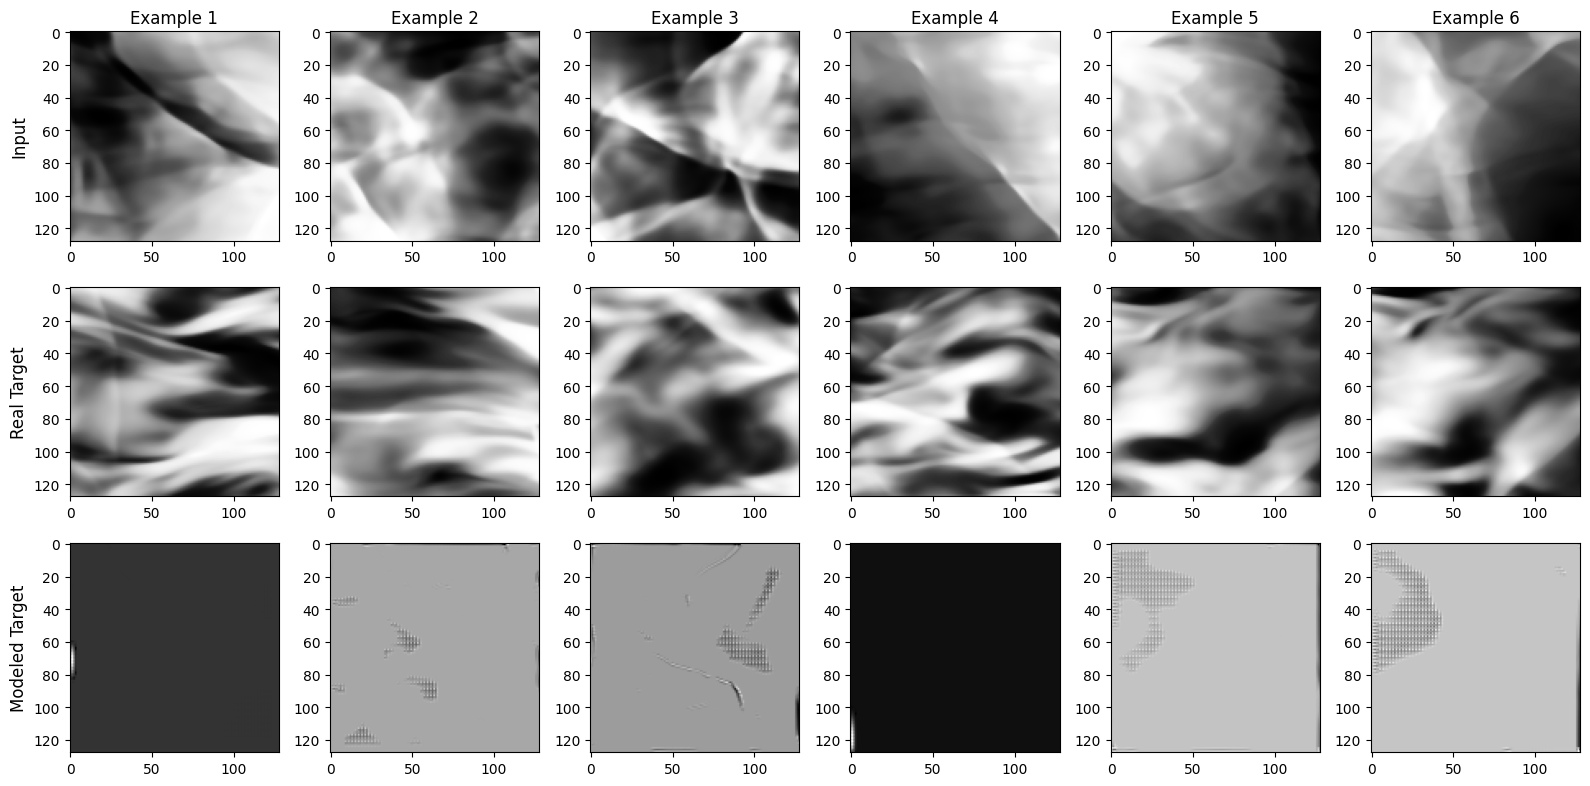

Epoch: 0 | Train Loss: 0.46822| Validation loss: 0.43809
Epoch: 1 | Train Loss: 0.43260| Validation loss: 0.43749
Saving model checkpoint
Epoch: 2 | Train Loss: 0.43259| Validation loss: 0.43756
Epoch: 3 | Train Loss: 0.43257| Validation loss: 0.43747
Saving model checkpoint
Epoch: 4 | Train Loss: 0.43274| Validation loss: 0.44078
Epoch: 5 | Train Loss: 0.43248| Validation loss: 0.43826
Saving model checkpoint
Epoch: 6 | Train Loss: 0.43242| Validation loss: 0.43729
Saving model checkpoint
Epoch: 7 | Train Loss: 0.43237| Validation loss: 0.43734
Epoch: 8 | Train Loss: 0.43237| Validation loss: 0.43760


KeyboardInterrupt: ignored

In [17]:
# run the model for different batch sizes
torch.cuda.empty_cache()

!mkdir 'runs'

batch_size = 32
config.epochs = 20
for alpha in [0.02, 0.1, 0.5]:
  run_name = 'batch_size_'+str(batch_size)+'_ssimalpha_'+str(alpha)+'_lr_1e-2'
  config.batch_size = batch_size
  config.run_name = run_name

  # load data
  train_dl, valid_dl, test_dl = load_data.preprocess(config)

  # create new model  
  model, loss_fn, opt = create_model(config)

  # run new model
  run_output = fit(config, model.to(device), loss_fn, opt, train_dl, valid_dl, alpha)
  model_trained, loss_arr_train, loss_arr_val, struc_arr_train, struc_arr_val = run_output
  
  # assumes training and validation loss are each quantified at every epoch
  num_epochs_run = np.arange(1,len(loss_arr_train)+1)

  # plotting parameters
  fs = 20

  if config.use_ssim:
    new_struc_arr_train = []
    for t in struc_arr_train:
      #t = t.cpu().detach().numpy()
      new_struc_arr_train.append(t)

    new_struc_arr_val = []
    for t in struc_arr_val:
      #t = t.cpu().detach().numpy()
      new_struc_arr_val.append(t)

  plt.plot(num_epochs_run, loss_arr_train, 'b-', label = f"Total Training Loss", lw=2)
  plt.plot(num_epochs_run, loss_arr_val, 'g-', label = f"Total Validation Loss", lw=2)
  if config.use_ssim:
    plt.plot(num_epochs_run, alpha*(np.ones(len(new_struc_arr_train))-new_struc_arr_train), 'b--', label = f"Training Loss due to SSIM", lw=2)
    plt.plot(num_epochs_run, alpha*(np.ones(len(new_struc_arr_val))-new_struc_arr_val), 'g--', label = f"Validation Loss due to SSIM", lw=2)
  
  plt.xlabel("Epoch", fontsize=fs)
  plt.title('batch size = ' + str(batch_size))
  plt.legend()
  plt.savefig(config.save_dir+run_name+'_Loss.png',dpi=600)
  plt.close()
  
  if config.use_ssim:
    plt.plot(num_epochs_run, new_struc_arr_train, label = f"Training SSIM", lw=2)
    plt.plot(num_epochs_run, new_struc_arr_val, label = f"Validation SSIM", lw=2)
    plt.xlabel("Epoch", fontsize=fs)
    plt.title('batch size = ' + str(batch_size))
    plt.legend()
    plt.savefig(config.save_dir+run_name+'_SSIM.png',dpi=600)
    plt.close()

  # Show comparison on training data instead of validation data
  print("Results on training data")
  plot_results(config, model_trained.cpu(), train_dl)

  print("Results on validation data")
  plot_results(config, model_trained.cpu(), valid_dl)


Results on training data


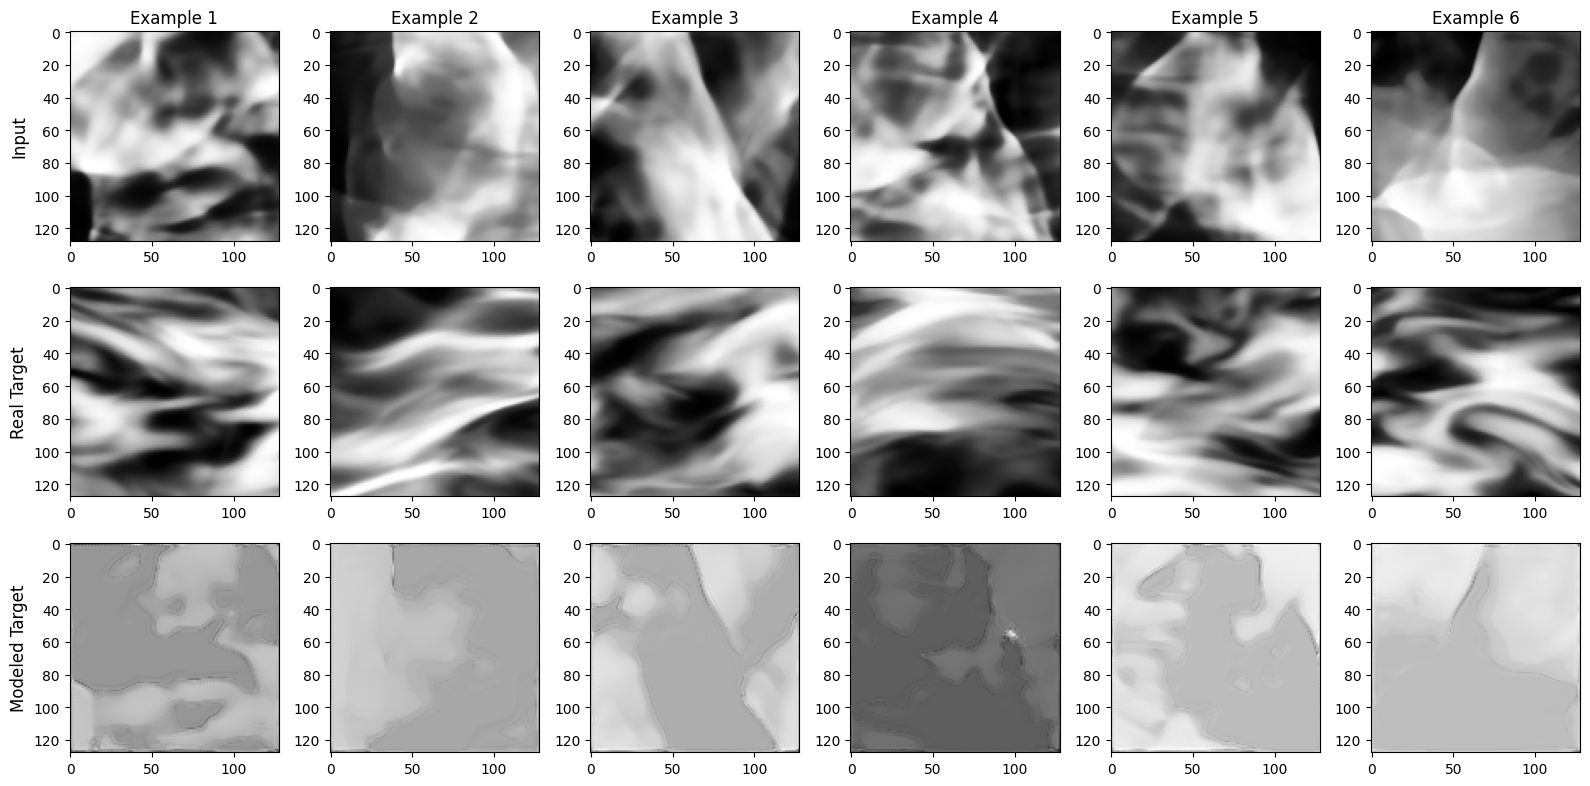

Results on validation data


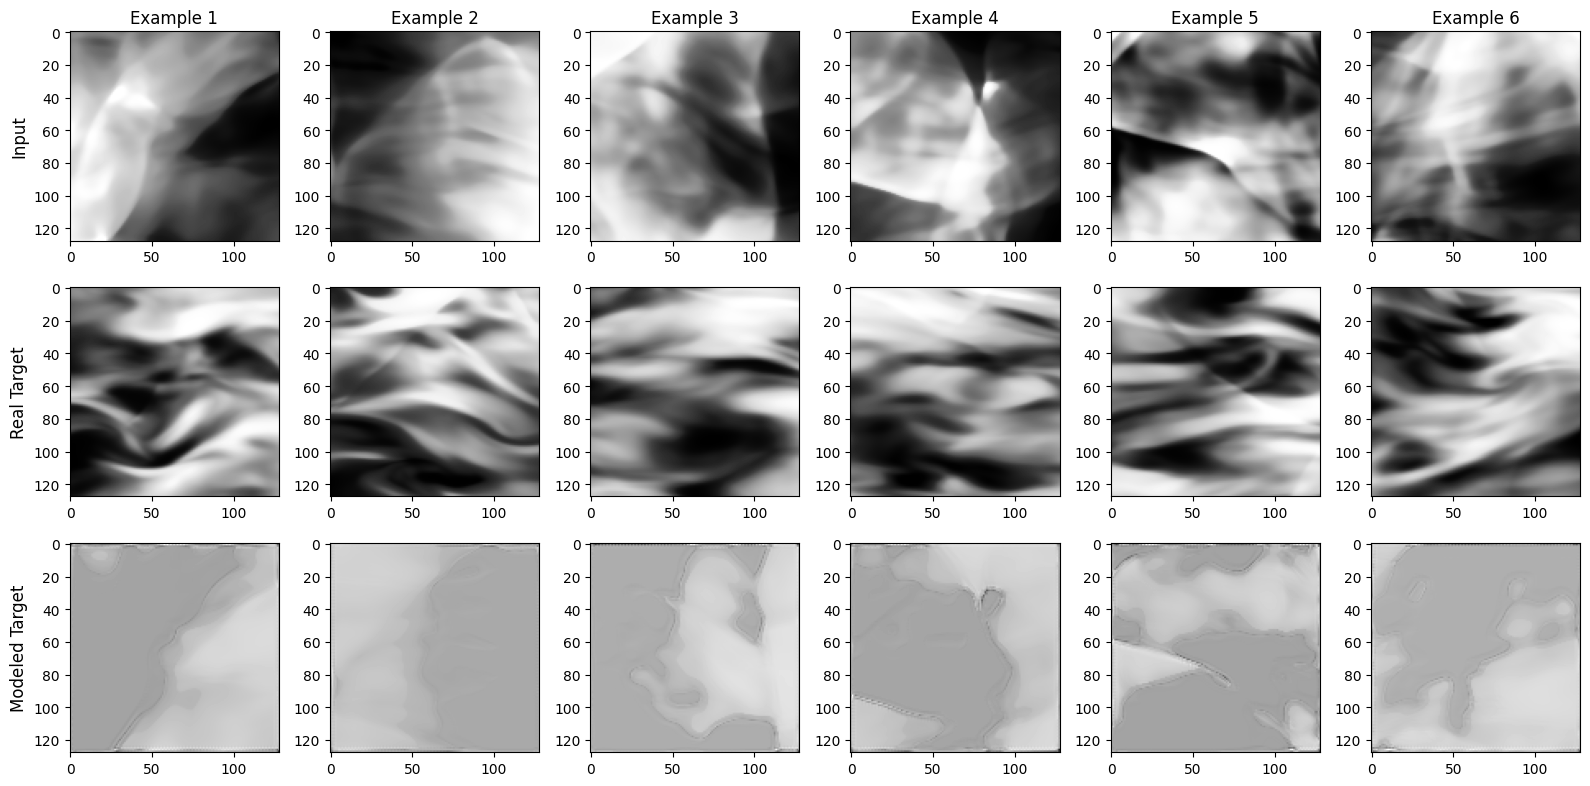

In [9]:
# Show comparison on training data instead of validation data
print("Results on training data")
plot_results(config, model_trained.cpu(), train_dl)

print("Results on validation data")
plot_results(config, model_trained.cpu(), valid_dl)